In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import optuna
import keras.backend as Ks
import keras
from keras.models import load_model 
from keras.models import Sequential, Model
from keras import layers 
from keras import Input
from keras import regularizers
from keras.utils import np_utils
import pickle
import random, secrets
import scipy.signal
import tensorflow as tf

from secrets import randbelow as rb
from scipy.optimize import curve_fit as cf
from numpy import load, asarray, savez_compressed, save, load, savetxt

Using TensorFlow backend.


In [2]:
# 学習データ読み込み
data_x = np.load('./spectrum_Bq_randcount_10RIUDC_2048_100-10M_roll.npy')


for i in range(data_x.shape[0] * 2) : #学習データをランダムに並替え
    index_a = random.randint(0, data_x.shape[0]-1)
    index_b = random.randint(0, data_x.shape[0]-1)
    data_x[index_a], data_x[index_b] = np.array(data_x[index_b]), np.array(data_x[index_a])

data_y = data_x[:, :10] # 学習データ（スペクトル）
data_x = data_x[:, 10:] # 学習データ（目的変数）
print(data_x.shape, data_y.shape) 
#data_nx = data_x / np.sum(data_x, axis=1, keepdims=True)
#print(np.sum(data_y), np.sum(data_nx))

(1228800, 413) (1228800, 10)


In [2]:

# The sequence is as below !!!
dir = "Nuclides/"
Co = np.loadtxt(dir+"Co-del.txt")
Na = np.loadtxt(dir+"Na-del.txt")
Cs = np.loadtxt(dir+"Cs-del.txt")
Ba = np.loadtxt(dir+"Ba-del.txt")
K  = np.loadtxt(dir+"K.txt")
Eu = np.loadtxt(dir+"Eu.txt")
U233=np.loadtxt(dir+"U233.txt")
U235=np.loadtxt(dir+"U235.txt")
U238=np.loadtxt(dir+"U238.txt")
Th = np.loadtxt(dir+"Th.txt")
Ra = np.loadtxt(dir+"Ra.txt")

nuclides_n = len([Co, Na, Cs, Ba, K, Eu, U233, U235, U238, Th, Ra])
print("Number of nuclides = ",nuclides_n)

ExpCo60  = np.loadtxt(dir+"/ExpCo-del.txt")
ExpNa22  = np.loadtxt(dir+"/ExpNa-del.txt")
ExpCs137 = np.loadtxt(dir+"/ExpCs-del.txt")
ExpBa133 = np.loadtxt(dir+"/ExpBa-del.txt")

rng = secrets.SystemRandom()
rng.randrange(-8,7)

Co = Co.T
Na = Na.T
Cs = Cs.T
Ba = Ba.T
K  = K.T
Eu = Eu.T
U233=U233.T
U235=U235.T
U238=U238.T
Th = Th.T
Ra = Ra.T

# print(Co[1,:])

TotBq = []
Co_Bq = []
Na_Bq = []
Cs_Bq = []
Ba_Bq = []
K_Bq  = []
Eu_Bq = []
U233_Bq=[]
U235_Bq=[]
U238_Bq=[]
Th_Bq = []
Ra_Bq = []

Sumpeak = []
randEshift=[]

CoCCR = []
NaCCR = []
CsCCR = []
BaCCR = []
KCCR  = []
EuCCR = []
U233CCR=[]
U235CCR=[]
U238CCR=[]
ThCCR = []
RaCCR = []


pattern = 2048
bit1 = 100
bit2 = 1000
bit3 = 10000
bit4 = 100000
bit5 = 1000000
bit6 = 10000000

bits = [bit1, bit2, bit3, bit4, bit5, bit6]

Eshiftpatterns = [i for i in range(100)]

Datasize = 500    # only first 500 channels of data is taken
Measurement_time = 60.0  # in seconds



ERROR! Session/line number was not unique in database. History logging moved to new session 62
Number of nuclides =  11


In [3]:
for Eshift in Eshiftpatterns:  
   
    s1 = secrets.choice(range(-8,7))     # rolling about 
    randEshift.append(s1)
    
    tempCo = np.roll(Co, -s1, axis=1)
    tempNa = np.roll(Na, -s1, axis=1)
    tempCs = np.roll(Cs, -s1, axis=1)
    tempBa = np.roll(Ba, -s1, axis=1)
    tempK  = np.roll(K, -s1, axis=1)
    tempEu = np.roll(Eu, -s1, axis=1)
    tempU233=np.roll(U233, -s1, axis=1)
    tempU235=np.roll(U235, -s1, axis=1)
    tempU238=np.roll(U238, -s1, axis=1)
    tempTh = np.roll(Th, -s1, axis=1)
    tempRa = np.roll(Ra, -s1, axis=1)
    
    for bit in bits:
        for i in range(pattern):
            x1 = rb(bit)
            x2 = rb(bit)
            x3 = rb(bit)
            x4 = rb(bit)
            x5 = rb(bit)
            x6 = rb(bit)
            x7 = rb(bit)
            x8 = rb(bit)
            x11 = rb(bit)
            x9 = rb(bit)
            x10 = rb(bit)
            xsum = x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11

            Co_Bq.append(x1)
            Na_Bq.append(x2)
            Cs_Bq.append(x3)
            Ba_Bq.append(x4)
            K_Bq.append(x5)
            Eu_Bq.append(x6)
            U233_Bq.append(x7)
            U235_Bq.append(x8)
            U238_Bq.append(x9)
            Th_Bq.append(x10)
            Ra_Bq.append(x11)
            TotBq.append(xsum)
            
            co60 = np.round(Measurement_time *x1*tempCo[1,0:Datasize])  #小数点カウントが発生するため、round処理を行う必要があります。以下同様
            na22 = np.round(Measurement_time *x2*tempNa[1,0:Datasize])
            cs137 = np.round(Measurement_time*x3*tempCs[1,0:Datasize])
            ba133 = np.round(Measurement_time*x4*tempBa[1,0:Datasize])
            k40 = np.round(Measurement_time  *x5*tempK[1,0:Datasize])  #小数点カウントが発生するため、round処理を行う必要があります。以下同様
            eu152 = np.round(Measurement_time*x6*tempEu[1,0:Datasize])
            u233 = np.round(Measurement_time *x7*tempU233[1,0:Datasize])
            u235 = np.round(Measurement_time *x8*tempU235[1,0:Datasize])
            u238 = np.round(Measurement_time *x9*tempU238[1,0:Datasize])
            th232 = np.round(Measurement_time*x10*tempTh[1,0:Datasize])
            ra226 = np.round(Measurement_time*x11*tempRa[1,0:Datasize])

            ww = co60 + na22 + cs137 + ba133 + k40 + eu152 + u233 + u235 + u238 + th232 + ra226
        
            Sumpeak.append(ww)
            
            CoCCR.append(np.sum(co60,axis=0)/np.sum(ww,axis=0))
            NaCCR.append(np.sum(na22,axis=0)/np.sum(ww,axis=0))
            CsCCR.append(np.sum(cs137,axis=0)/np.sum(ww,axis=0))
            BaCCR.append(np.sum(ba133,axis=0)/np.sum(ww,axis=0))
            KCCR.append(np.sum(k40,axis=0)/np.sum(ww,axis=0))
            EuCCR.append(np.sum(eu152,axis=0)/np.sum(ww,axis=0))
            U233CCR.append(np.sum(u233,axis=0)/np.sum(ww,axis=0))
            U235CCR.append(np.sum(u235,axis=0)/np.sum(ww,axis=0))
            U238CCR.append(np.sum(u238,axis=0)/np.sum(ww,axis=0))
            ThCCR.append(np.sum(th232,axis=0)/np.sum(ww,axis=0))
            RaCCR.append(np.sum(ra226,axis=0)/np.sum(ww,axis=0))
            
            

Sum = np.vstack((Co[0,0:Datasize], Sumpeak))


In [4]:
X_train = np.array(Sumpeak)
CCR = np.vstack([CoCCR, NaCCR, CsCCR, BaCCR, KCCR, EuCCR, U233CCR, U235CCR, U238CCR, ThCCR, RaCCR])

Y_train = CCR.T

save('X_train.npy', X_train)
save('Y_train.npy', Y_train)

print(X_train.shape)
print(np.shape(Y_train))

(1228800, 500)
(1228800, 11)


In [ ]:
load('X_train.npy')

In [5]:
# VGG19 model定義
Ks.clear_session()

VGG19model = keras.models.Sequential()

VGG19model.add(layers.Conv1D(64, 3, activation = 'relu', padding='same',
                       input_shape = (Datasize,1)))
VGG19model.add(layers.Conv1D(64, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.MaxPooling1D(2))

VGG19model.add(layers.Conv1D(128, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(128, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.MaxPooling1D(2))

VGG19model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.MaxPooling1D(2))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.MaxPooling1D(2))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG19model.add(layers.MaxPooling1D(2))
VGG19model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
VGG19model.add(layers.Dense(1024, activation='relu'))
VGG19model.add(layers.Dense(1024, activation='relu'))
VGG19model.add(layers.Dropout(0.5))
VGG19model.add(layers.Dense(nuclides_n, activation='softmax'))

#opt= keras.optimizers.Adam(lr=0.0021533133440412807,
#                           decay=8.915893662822524e-09,
#                           amsgrad=True)
opt = keras.optimizers.Adam()

VGG19model.compile(loss='categorical_crossentropy', optimizer=opt)

VGG19model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 250, 128)          24704     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 125, 256)         

In [ ]:
# VGG16 model定義
Ks.clear_session()

VGG16model = keras.models.Sequential()

VGG16model.add(layers.Conv1D(64, 3, activation = 'relu', padding='same',
                       input_shape = (Datasize,1)))
VGG16model.add(layers.Conv1D(64, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.MaxPooling1D(2))
VGG16model.add(layers.Conv1D(128, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(128, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.MaxPooling1D(2))
VGG16model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(256, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.MaxPooling1D(2))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.MaxPooling1D(2))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.Conv1D(512, 3, padding='same', activation = 'relu'))
VGG16model.add(layers.MaxPooling1D(2))
VGG16model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
VGG16model.add(layers.Dense(1024, activation='relu'))
VGG16model.add(layers.Dense(1024, activation='relu'))
VGG16model.add(layers.Dropout(0.5))
VGG16model.add(layers.Dense(10, activation='softmax'))

#opt= keras.optimizers.Adam(lr=0.0021533133440412807,
#                           decay=8.915893662822524e-09,
#                           amsgrad=True)
opt = keras.optimizers.Adam()

VGG16model.compile(loss='categorical_crossentropy', optimizer=opt)

VGG16model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 413, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 413, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 206, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 206, 128)          24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 206, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 103, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 103, 256)          9

In [4]:
print(data_y.shape)
print(data_x.shape)

data_x = data_x.reshape(data_x.shape[0], data_x.shape[1], 1) # 学習データをConv1D Layer用に変形
#data_nx = data_nx.reshape(data_nx.shape[0], data_nx.shape[1], 1)
print(data_x.shape) #, data_nx.shape)

(1228800, 10)
(1228800, 413)
(1228800, 413, 1)


In [6]:
print(X_train.shape)
print(Y_train.shape)

data_x = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # 学習データをConv1D Layer用に変形
print(data_x.shape)

data_y = Y_train

(1228800, 500)
(1228800, 11)
(1228800, 500, 1)


Train on 1105920 samples, validate on 122880 samples
Epoch 1/5
1105920/1105920 [==============================] - 824s 745us/step - loss: 8.9944 - val_loss: 1.7831
Epoch 2/5
1105920/1105920 [==============================] - 817s 739us/step - loss: 1.7881 - val_loss: 1.7789
Epoch 3/5
1105920/1105920 [==============================] - 818s 740us/step - loss: 1.7839 - val_loss: 1.7769
Epoch 4/5
1105920/1105920 [==============================] - 818s 739us/step - loss: 1.7824 - val_loss: 1.7764
Epoch 5/5
1105920/1105920 [==============================] - 818s 740us/step - loss: 1.7813 - val_loss: 1.7755


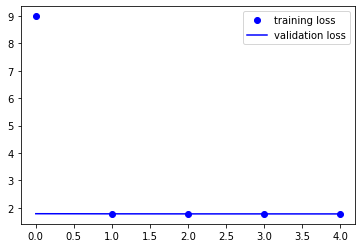

In [7]:
#VGG19 学習
from keras.callbacks import EarlyStopping

VGGhistory = VGG19model.fit(data_x, data_y, 
                    epochs=5,
                    batch_size=1024,
                    validation_split=0.1)
#                    callbacks=EarlyStopping(monitor='val_loss',patience=50, verbose=1, min_delta=0,mode="auto"))

VGGloss = VGGhistory.history['loss']
VGGval_loss = VGGhistory.history['val_loss']

#epochs= range(len(acc))
epochs= range(len(VGGloss))
#plt.plot(epochs, acc, 'bo', label='training acc')
#plt.plot(epochs, val_acc, 'b', label='validation acc')
#plt.legend()
plt.figure()
plt.plot(epochs, VGGloss, 'bo', label='training loss')
plt.plot(epochs, VGGval_loss, 'b', label='validation loss')
plt.legend()

plt.show()

In [8]:
VGG19model.save("VGG19-1D_5epoch_11nuc.h5")

In [6]:
#VGG19model.save("/content/drive/My Drive/ML/1D-CNN/tmp/VGG19-1D_2kX100-10M_Roll_PCData_100epoch.h5")
VGG19model = keras.models.load_model("./VGG19-1D_2kX100-10M_Roll_100epoch.h5")

In [ ]:
test = np.load("./RI-mesured_3.51keV.npy") #RI用テストデータ

 
test_x = test[:, 8:] # テストデータ
test_y = test[:, :8] # テストデータ目的変数
test_y[15] = [0., 0., 0., 0.226649, 0.566476, 0., 0., 0.206875]
print(test_x.shape, test_y.shape)

#test_nx = test_x / np.sum(test_x, axis=1, keepdims=True)
print(test_y)

(16, 413) (16, 8)
[[0.7956236  0.         0.         0.         0.         0.
  0.         0.20437641]
 [0.         0.78972659 0.         0.         0.         0.
  0.         0.21027341]
 [0.         0.         0.81744614 0.         0.         0.
  0.         0.18255386]
 [0.         0.         0.         0.52280702 0.         0.
  0.         0.47719298]
 [0.         0.         0.         0.         0.74527031 0.
  0.         0.25472969]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.45012049 0.43425447 0.         0.         0.         0.
  0.         0.11562504]
 [0.41543368 0.         0.47785148 0.         0.         0.
  0.         0.10671484]
 [0.65006581 0.         0.         0.18294805 0.         0.
  0.         0.16698614]
 [0.49790263 0.         0.         0.         0.37419826 0.
  0.         0.12789911]
 [0.         0.40674645 0.48495282 0.         0.         0.
  0.         0.10830073]
 [0.         0.64185946 0.         0.18723839 0

In [11]:
Utest = np.loadtxt("./U-mesured_3.51keV.csv", delimiter=',', skiprows=1) # U用テストデータ
print(Utest.shape)

(20, 413)


(16, 413, 1)


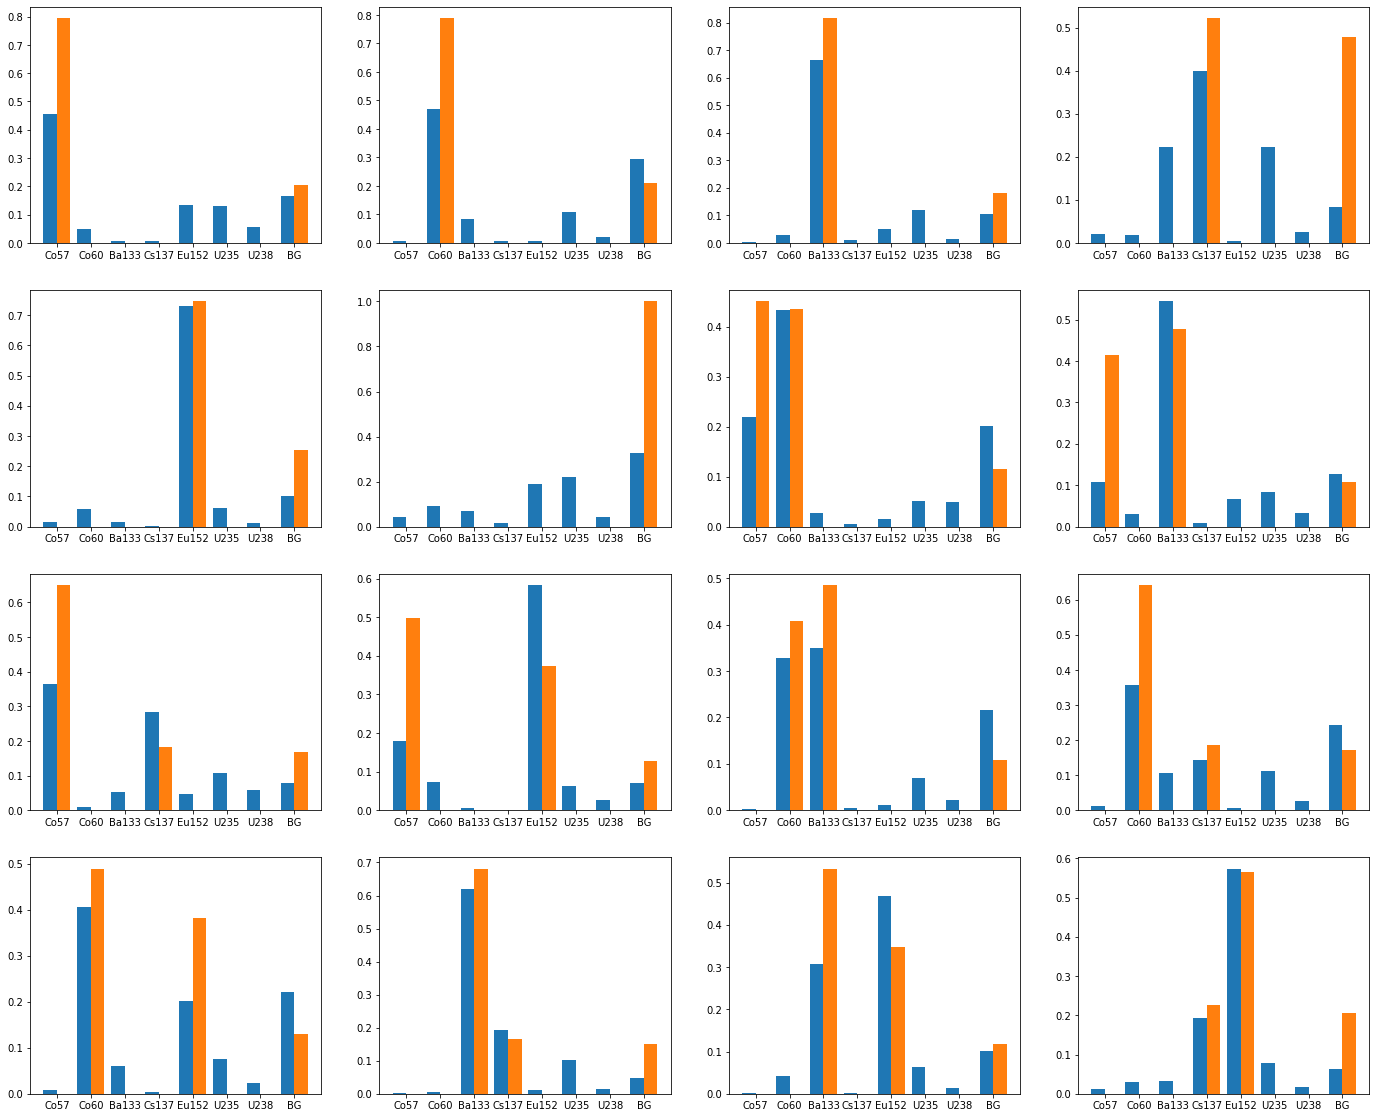

In [ ]:
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)
print(test_x.shape)

result_y = VGG19model.predict(test_x)
BG = result_y[:, 5] + result_y[:, 6] + result_y[:, 9]
BG = BG.reshape(BG.shape[0], 1)
result_y = np.hstack((result_y[:, :5], result_y[:, 7:9], BG))


names = np.array(["Co57", "Co60", "Ba133", "Cs137", "Eu152", "U235", "U238", "BG"])

left = np.arange(result_y.shape[1])
width = 0.4

plt.figure(figsize=(24, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.bar(left, result_y[i], width=width, align='center')
    plt.bar(left+width, test_y[i], width=width, align='center')
    plt.xticks(left + width/2, names)
    #plt.ylim(0, 0.5)
plt.show()

(20, 413, 1)
[[0.10132912 0.05003193 0.01606422 0.01084351 0.2719764  0.00327973
  0.27179062 0.18714604 0.07084837 0.01669007]
 [0.09996117 0.02732188 0.01475745 0.02431816 0.32552156 0.00203317
  0.24645141 0.17652477 0.05926369 0.02384682]
 [0.09232266 0.03381047 0.01380578 0.00172667 0.2865393  0.04332508
  0.29535478 0.16966812 0.05047383 0.01297328]
 [0.10989687 0.03380335 0.02595475 0.03712627 0.2132394  0.01657209
  0.28544572 0.19244911 0.06381425 0.02169821]
 [0.14086486 0.10014626 0.0027311  0.02750296 0.17606594 0.01340101
  0.23865925 0.216864   0.06142239 0.02234224]
 [0.10592092 0.07181361 0.00665724 0.08584048 0.21264488 0.08960786
  0.20263459 0.15078568 0.05390098 0.02019373]
 [0.1216211  0.06430724 0.0087512  0.03736378 0.22504967 0.03164472
  0.24775603 0.19730276 0.05904478 0.0071587 ]
 [0.12494504 0.09824163 0.00688946 0.02704834 0.21717015 0.06709505
  0.23765641 0.16922225 0.04851435 0.00321733]
 [0.11154459 0.06140976 0.00634874 0.00580108 0.19927889 0.19121784

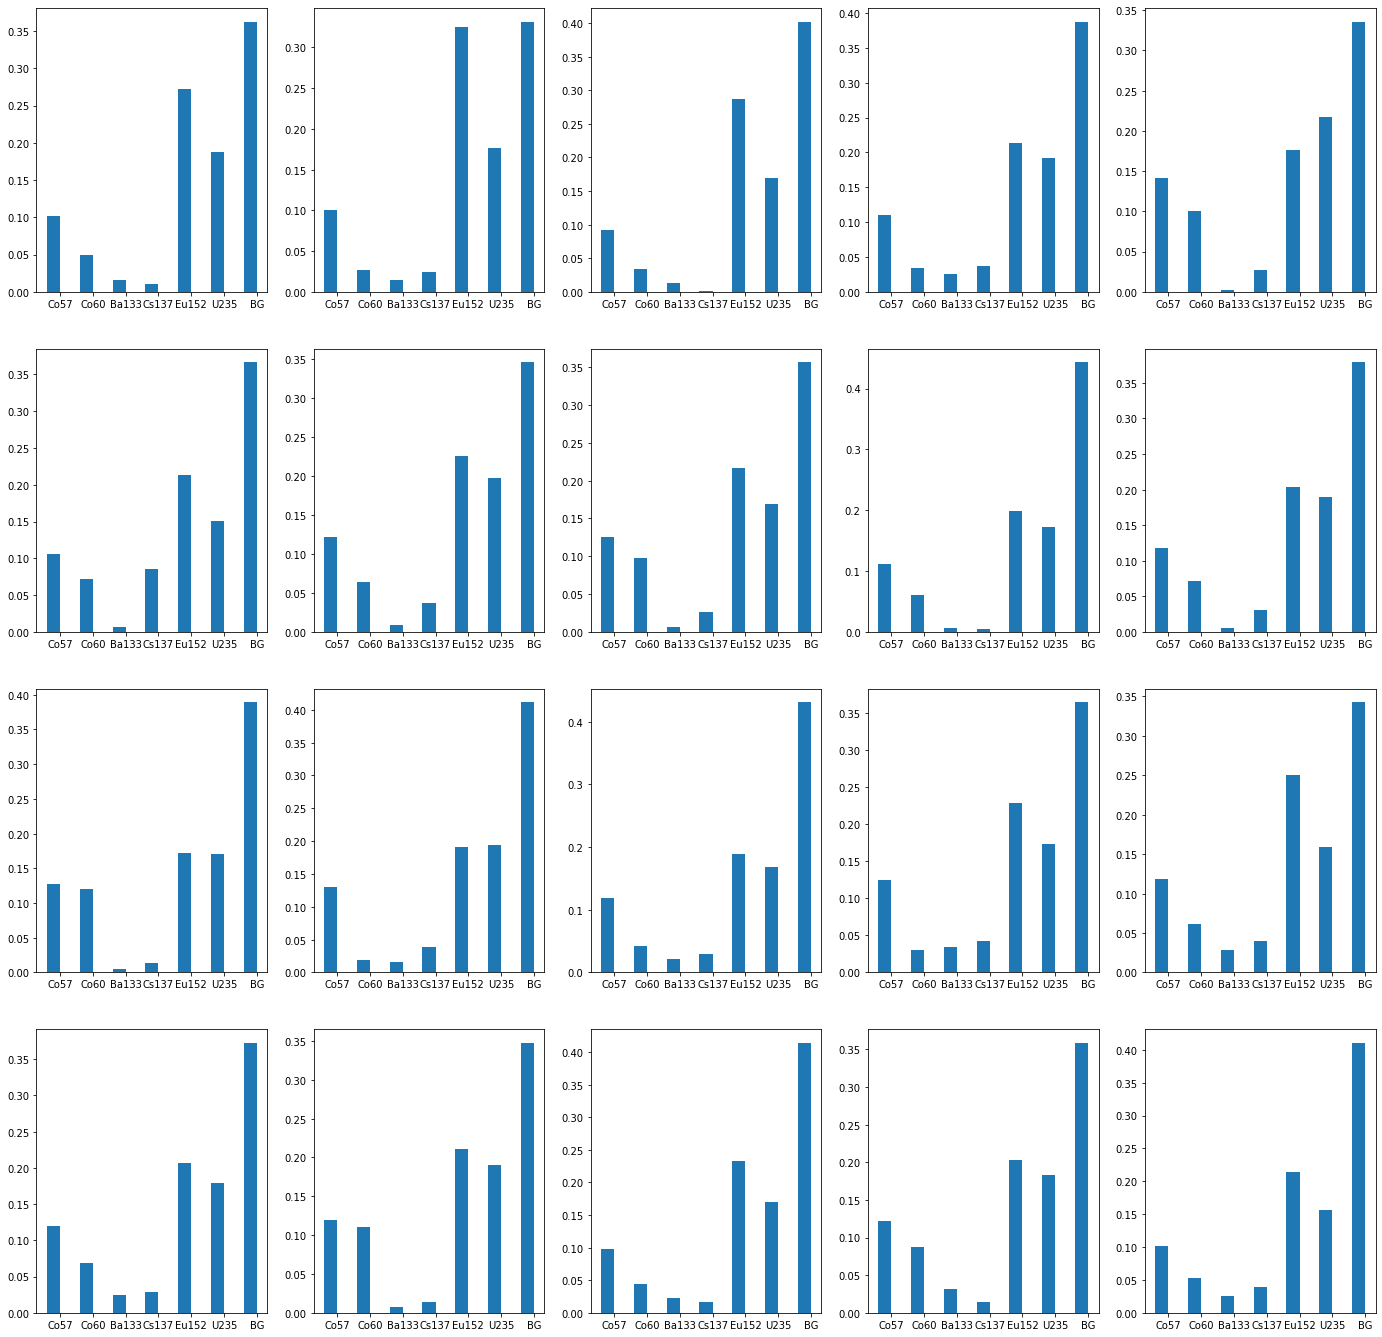

In [13]:
# 1D-VGG19 2k-Roll 100-10MBq 100epoch
Utest = Utest.reshape(Utest.shape[0], Utest.shape[1], 1)
print(Utest.shape)

Uresult_y = VGG19model.predict(Utest)
#BG = result_y[:, 5] + result_y[:, 6] + result_y[:, 9]
#BG = BG.reshape(BG.shape[0], 1)
#result_y = np.hstack((result_y[:, :5], result_y[:, 7:9], BG))
print(Uresult_y)

BG = Uresult_y[:, 5] + Uresult_y[:, 6] + Uresult_y[:, 8] + Uresult_y[:, 9]
BG = BG.reshape(BG.shape[0], 1)
Uresult_y = np.hstack((Uresult_y[:, :5], Uresult_y[:, 7:8], BG))



#names = np.array(["Co57", "Co60", "Ba133", "Cs137", "Eu152", "U235", "U238", "BG"])
names = np.array(["Co57", "Co60", "Ba133", "Cs137", "Eu152", "U235", "BG"])


left = np.arange(Uresult_y.shape[1])
width = 0.4

plt.figure(figsize=(24, 24))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.bar(left, Uresult_y[i], width=width, align='center')
    #plt.bar(left+width, test_y[i], width=width, align='center')
    plt.xticks(left + width/2, names)
    #plt.ylim(0, 0.5)
plt.show()